## This notebook builds a probabilistic model with Pymc3 to extend the MSqRob ridge regression model
https://www.ncbi.nlm.nih.gov/pubmed/28391044
$$
y_{ijkl} = \beta_{ij}^{treatment} + \beta_{ik}^{peptide} + \epsilon_{in}
$$

where $y$ stands for the $log_2$-transformed intensity of each peptide $k$ in run $l$ and condition $j$ that belong to protein $i$. $n$ is the $n^{th}$ peptide and $\epsilon$ is an noise term following a normal distribution with $mu$ = 0 and sigma $\sigma_i$ specific to the protein.
Each $\beta$ models a different effect on the final intensity measurement. The treatment effect \beta^{treatment} can be regarded as an estimate of the $\log_2$ protein quantity. Thus, \beta_{ij}^{treatment A} - \beta_{ij}^{treatment B} is an estimate of the $log_2$ fold change of protein $i$ between conditions A and B.

Independent ridge regression models are built for all N peptides under protein $i$.

In this notebook, the fold change of the proteins detected in the MaxLFQ proteomebenchmark dataset: https://www.ebi.ac.uk/pride/archive/projects/PXD000279 is modeled in a similar way with a new extension.

The peptides.txt file from MaxQuant was read in R and preprocessed with MSqRob preprocess_MaxQuant().

Sequence features are extracted from each peptide to better capture the sequence variability inherent to each peptide.
The sequence features were extracted using the protr package in R using extractAPAAC(), which yields a numeric vector of 32 features for each peptide, independent of length.
Additionally to these 3 features, the number of missed cleavages of the peptide, and an integer encoding the neighboring residues of the peptide in the protein were added to the features, giving 35 features in total.

The sequence features are used to model the peptide effect \beta_{ik}^{peptide}.

$$
\beta_{ik}^{peptide} = \theta * features_{ik}
$$

which multiplies the intensities $y$ in the ridge regression model above, rendering a new model:

$$
y_{ijkln} = \beta^{treatment}_{ij} \beta_{ik}^{peptide} + \epsilon_{in}
$$


In [1]:
import pymc3 as pm
import theano

/home/antortjim/anaconda3/envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import pandas as pd
import os.path
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(123)
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
# %load model_vectorized.py
import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from theano import shared
import shutil
import os
from exp_annot_funcs import *

def protein_model(observed_shared, features_p_shared, x_treat_shared, x_pep_shared, x_run_shared, x_estimate_shared, n_peptides, model_name, n_draws=1000, n_chains=3, hierarchical_center=False, advi=True, remove_backend=True, sequence=False):
 

    """
    Compiles a PYMC3 model to infer the log2FC for protein p
    between two conditions with different treatments,
    i.e the treatment effect

    Keywords:

        -proteins: a string list storing the protein name: ex O43663

        -features: a DataFrame of size nxk where n is the number of peptides available
            in the experiment and k the number of features extracted in a previous step
        
        -sequence: boolean controlling if the sequence features should be used
            to model the variance across peptides of the same protein


        -n_draws: integer. How many draws (sampling) should pymc3 take=?
        -n_chains: integer. How many chains should be run in parallel?

        
   
    The algorithm models the protein quantities with 2 linear regressions:

      The main GLM is used to predict the quant_value from MS1 based on:
          treat: the effect of the treatment
          pep: the effect of the peptide (batch/sequence effect) 
      Other effects may be added, such as fraction
 
      The secondary GLM is built to model pep as a function of features
      extracted from either the peptide or the peptide in combination
      with its surroundings in the protein environment.
      The environment is defined as the 15 residue window on each side
       
      The sequence featues passed should be those listed
      in table 3 from https://www.ncbi.nlm.nih.gov/pubmed/16873510
      Table 3 shows the features that best performed while
      predicting the peptide observability
      
    This function returns a tuple with the trace, the model itself,
    and 2 qc objects
                
   
    """

    if not os.path.isdir("traces") or not os.path.isdir("plots/traceplots"):
        raise Exception("Please create a traces dir and a plots/traceplots dir before running this code")


    trace_name = 'traces/{}'.format(model_name)
    traceplot = "plots/traceplots/{}.png".format(model_name)

    if remove_backend and os.path.isdir(model_name):
        shutil.rmtree(model_name)

    # Get the data for the current protein being analyzed
    n_features = 9
    n_proteins = 1
    



    with pm.Model() as model:
            
        intercept = pm.Normal("intercept", 22, 1)
        
        # sigma will be some random error protein specific variance
        sigma = pm.HalfNormal('sigma', 1)
        sigma_pep = pm.HalfNormal('sigma_pep', 1)

        if not sequence:
            mu_pep = pm.Normal('mu_pep', mu=0, sd=sigma_pep, shape=(n_peptides, 1))
        else: 
            # sequence based modelling
            mu_theta = pm.Normal('theta_generic', 0, sigma_pep, shape = 1)
            theta = pm.Normal('theta', mu_theta, sigma_pep, shape = (n_features, 1))    # 9x1
            theta_intercept = pm.Normal('theta_intercept', mu_theta, sigma_pep, shape = 1)
            mu_pep = pm.Deterministic("mu_pep", theta_intercept + features_p_shared.dot(theta)) # n_peptidesx1

        sigma_treat = pm.HalfNormal('sigma_treat', 1)
        mu_treat = pm.Normal('mu_treat', 0, sigma_treat)
        sigma_run = pm.HalfNormal('sigma_run', 1)
        mu_run = pm.Normal('mu_run', 0, sigma_run)

        if hierarchical_center:
            pep = pm.Normal("pep", mu_pep, sigma_pep) # n_peptidesx1
            treat = pm.Normal('treat', mu_treat, sigma_treat, shape = (n_proteins*2, 1))
            run = pm.Normal('run', mu_run, sigma_run, shape = (n_proteins*6, 1))
        else:
            pep_offset = pm.Normal("pep_offset", mu=0, sd=1, shape = (n_peptides, 1))
            pep = pm.Deterministic("pep", mu_pep + pep_offset * sigma_pep)
            treat_offset = pm.Normal("treat_offset", mu=0, sd=1, shape=(n_proteins*2, 1))
            treat = pm.Deterministic("treat", mu_treat + treat_offset*sigma_treat)
            run_offset = pm.Normal("run_offset", mu=0, sd=1, shape=(n_proteins*6, 1))
            run = pm.Deterministic("run", mu_run + run_offset*sigma_run)


        # When there is only one protein, thi equals to treat[0] - treat[1]
        estimate = pm.Deterministic('estimate', pm.math.sum(x_estimate_shared.dot(treat), axis=1))
        treatment_effect = pm.Deterministic("treatment_effect", pm.math.sum(x_treat_shared.dot(treat), axis=1))
        peptide_effect = pm.Deterministic("peptide_effect", pm.math.sum(x_pep_shared.dot(pep), axis=1))
        run_effect = pm.Deterministic("run_effect", pm.math.sum(x_run_shared.dot(run), axis=1))

        # Likelihood function for the data.
        mu = pm.Deterministic("mu", intercept + treatment_effect + peptide_effect + run_effect) #n_peptides*6x1
        if hierarchical_center:
            obs = pm.Normal("obs", mu, sigma, observed=observed_shared)
        else:
            obs_offset = pm.Normal("obs_offset", mu=0, sd=1, shape=(n_peptides*6,1))
            obs = pm.Normal("obs", mu+obs_offset*sigma, sigma, observed=observed_shared)


    print("Success: Model {} compiled".format(model_name))

    with model:
        # Parameters of the simulation:
        # Number of iterations and independent chains.
        n_sim = n_draws*n_chains

        # Save traces to the Text backend i.e a folder called model_name containing csv files for each chain
        db = pm.backends.Text(trace_name)
        if not advi:
            trace = pm.sample(draws=n_draws, njobs=n_chains, trace=db, tune=2000, nuts_kwargs=dict(target_accept=.95))
#        else:
#            inference = pm.ADVI()
#            approx = pm.fit(n=30000, method=inference, callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])
#            trace = approx.sample(draws=n_draws)
#            plt.plot(-inference.hist, label='ADVI', alpha=.3)
#            plt.legend()
#            plt.ylabel('ELBO')
#            plt.xlabel('iteration');
#            plt.savefig("elbos/ELBO_{}.png".format(model_name))
#    
    pm.traceplot(trace, varnames=["estimate"])
    plt.savefig(traceplot)
    plt.close()
       
    return model


In [4]:
# %load exp_annot_funcs.py
import numpy as np
import pandas as pd
from tqdm import tqdm

def create_x_pep(data):

    observed=data.values[:,2:].flatten().astype(float)
    x_pep = np.zeros((len(observed), data.shape[0]))
    k=0
    for i in range(x_pep.shape[1]):
        x_pep[(0+k):(6+k),i] = 1
        k+=6


    print("Shape of x_pep is {}, {}".format(*x_pep.shape))
    return x_pep

def create_x_treat(data, n_proteins):
    observed=data.values[:,2:].flatten().astype(float)
    x_treat = np.zeros((len(observed), n_proteins * 2))
    
    proteins_column = data["protein"].values.tolist()
    last_protein = proteins_column[0]
    colIndex=0
    rowIndex=0
    acum = 0
    for i, p in tqdm(enumerate(proteins_column)):
        if p != last_protein:
            colIndex += 2
            last_protein=p
            acum += 1
        x_treat[(0+rowIndex):(3+rowIndex),colIndex] = 1
        x_treat[(3+rowIndex):(6+rowIndex),colIndex+1] = 1
    
        rowIndex += 6

    print("Shape of x_treat is {}, {}".format(*x_treat.shape))
    return x_treat

def create_x_run(data):
    observed=data.values[:,2:].flatten().astype(float)
    n_proteins = len(np.unique(data.protein))
    n_runs = 6
    x_run = np.zeros((len(observed),n_proteins*n_runs))

    last_protein = data.protein.values.tolist()[0]
    colIndex = 0
    rowIndex = 0
    acum = 0
    for p in data["protein"].values.tolist():
        if p != last_protein:
            colIndex += n_runs
            last_protein=p
            acum += 1

        for offset in range(n_runs):
            x_run[(rowIndex+offset), (colIndex+offset)]=1
        
        rowIndex += n_runs

    return x_run

         
def create_x_estimate(n_proteins):
    x_estimate = np.zeros((n_proteins, n_proteins*2))
    i=0
    j = 0
    for i in range(x_estimate.shape[0]):
        x_estimate[i,j]=1
        j+=1 
        x_estimate[i,j]=-1
        j+=1

    print("Shape of x_estimate is {}, {}".format(*x_estimate.shape))
    return x_estimate
    

def create_variables(data, features, proteins):
    data_p=data.loc[data.protein.isin(proteins),:]
    indices = data_p.index
    features_p = features.iloc[indices,:].values

    n_peptides = len(indices)
    n_proteins = len(proteins)
    n_features = features_p.shape[1]

    observed=data_p.values[:,2:].flatten().astype(float)
    #log2fc = np.array([0,0,0, log2fc, log2fc, log2fc,]*n_peptides)
    x_treat = create_x_treat(data_p, n_proteins)
    x_pep = create_x_pep(data_p)
    x_run = create_x_run(data_p)
    x_estimate = create_x_estimate(n_proteins)

    return (observed, features_p, x_treat, x_pep, x_run, x_estimate)

def load_stats(data, features, proteins):
    data_p=data.loc[data.protein.isin(proteins),:]
    
    observed=data_p.values[:,2:]
    mean_intercept = np.mean(observed[:,:3].flatten())
    observed=observed.flatten().astype(float)
    observed = np.expand_dims(observed, axis=0)

    indices = data_p.index
    features_p = features.iloc[indices,:].values
    n_peptides = len(indices)
    n_proteins = len(proteins)
    n_features = features_p.shape[1]


    return (n_peptides, n_proteins, n_features, mean_intercept)



In [5]:
data = pd.read_csv("data/data.tsv", sep = "\t")
data['H1'] = data['H1'].astype(theano.config.floatX)
data['H2'] = data['H2'].astype(theano.config.floatX)
data['H3'] = data['H3'].astype(theano.config.floatX)
data['L1'] = data['L1'].astype(theano.config.floatX)
data['L2'] = data['L2'].astype(theano.config.floatX)
data['L3'] = data['L3'].astype(theano.config.floatX)
data.head()

,protein,taxon,H1,H2,H3,L1,L2,L3
0,P37108,Homo sapiens,28.181535,28.006834,28.006941,27.133594,27.969390,27.869266
1,Q96P70,Homo sapiens,26.121057,25.893423,26.436157,25.421240,25.719706,25.811642
2,Q9Y2U8,Homo sapiens,22.398509,23.542741,24.042266,25.124118,25.285598,25.008512
3,Q9BTD8-4;Q9BTD8-2;Q9BTD8-3;Q9BTD8,Homo sapiens,23.337153,22.611060,23.675084,19.519606,23.237510,22.601230
4,Q9P258,Homo sapiens,22.545124,20.359925,22.185649,21.836265,22.880450,21.577547


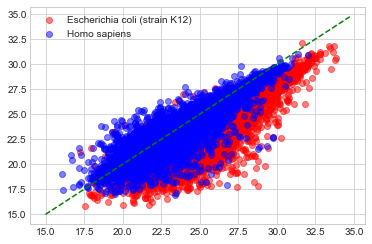

In [6]:
x=np.mean(data[["H1","H2","H3"]].values, axis=1)
y=np.mean(data[["L1","L2","L3"]].values, axis=1)
colors=["red", "blue"]
for i, taxon in enumerate(["Escherichia coli (strain K12)", "Homo sapiens"]):
    plt.scatter(x=x[data.taxon == taxon],y=y[data.taxon == taxon], c=colors[i],label=taxon, alpha=0.5)
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',color="green")
abline(1,0)
plt.legend()
plt.show()


In [7]:
mean_data = pd.DataFrame({"H":x,"L":y, "taxon":data.taxon})

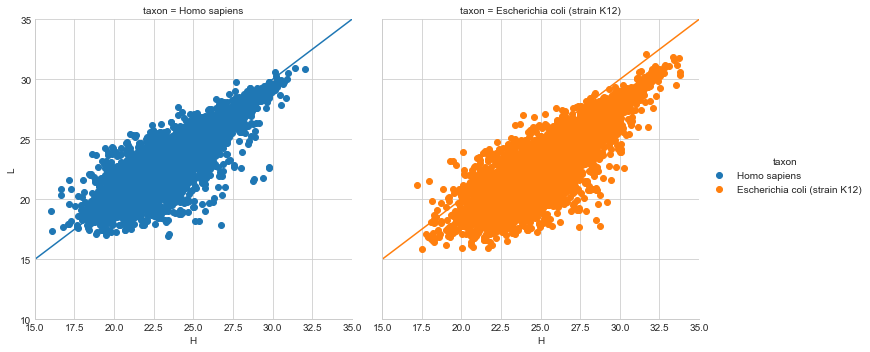

In [8]:
myPlot = sns.FacetGrid(col="taxon", hue='taxon', data=mean_data, size=5)
myPlot = myPlot.map(plt.scatter, "H", "L").set(xlim=(15,35) , ylim=(10,35))
myPlot = myPlot.map_dataframe(plt.plot, [15,35], [15,35], 'r-').add_legend().set_axis_labels("H", "L")
plt.show()

In [9]:
from numpy.linalg import norm
p1 = np.array([0,0])
p2 = np.array([1,1])
indices = [data.taxon == "Homo sapiens", data.taxon != "Homo sapiens"]
hsapiens_d, ecoli_d =np.array([[norm(np.cross(p2-p1, p1-p3))/norm(p2-p1) for p3 in zip(x[idx],y[idx])] for idx in indices])
print(np.mean(hsapiens_d))
print(np.mean(ecoli_d))



0.6005208785523234
1.6266920285619832


In [10]:
features = pd.read_csv("data/advanced_features.tsv", sep = "\t").iloc[:,1:]
features=features.iloc[data.index,:]
n_seq_feat = features.shape[1]
print("Number of sequence features {}".format(n_seq_feat))
n_prots = len(np.unique(data.protein))
print("Number of proteins {}".format(n_prots))
n_peptides = data.shape[0]
print("Number of peptides {}".format(n_peptides))
print("This is the first row of the features array:")
print(features.shape)
print(features.iloc[:1,:])
features.head()

Number of sequence features 9
Number of proteins 2850
Number of peptides 17107
This is the first row of the features array:
(17107, 9)
   aromaticity  composition_G  composition_K  composition_V  flexibility  \
0    -0.992459            1.0            0.0            0.0     1.648868   

   instability    length  mass_len_ratio        hm  
0       1.8288  1.286819       -2.053132 -1.516532  


,aromaticity,composition_G,composition_K,composition_V,flexibility,instability,length,mass_len_ratio,hm
0,-0.992459,1.0,0.0,0.0,1.648868,1.828800,1.286819,-2.053132,-1.516532
1,0.841374,1.0,1.0,0.0,-0.248549,-0.573767,-0.074351,-0.396156,-0.513330
2,-0.992459,1.0,0.0,0.0,0.804389,1.928472,-0.852162,1.468934,2.343718
3,-0.992459,1.0,1.0,1.0,-0.957520,0.058742,-0.657709,-1.121271,0.094526
4,-0.992459,1.0,1.0,1.0,-0.172332,-0.188579,0.120102,-1.097936,-1.934398


### Every protein has at least two peptides

In [11]:
counts = np.unique(np.unique(data.protein, return_counts=True)[1], return_counts=True)
pd.DataFrame(np.array([counts[0], counts[1]]).T, columns = ["n_peptides", "n_prots"]).head(10)

,n_peptides,n_prots
0,2,874
1,3,498
2,4,311
3,5,205
4,6,155
5,7,133
6,8,109
7,9,96
8,10,65
9,11,61


In [12]:
n=10
proteins, counts = np.unique(data.protein, return_counts=True)
proteins = np.random.choice(proteins[counts == 2], size=n)

In [13]:
# trace, model, _, _ = protein_model(data_dict, protein, features, proteins_dict)
n_draws=5000
n_chains=3
i=0
variables = create_variables(data=data, features=features, proteins=[proteins[i]])
observed_shared, features_p_shared, x_treat_shared, x_pep_shared, x_run_shared, x_estimate_shared = map(shared, variables)
# stats = load_stats(data, features, [proteins[0]])
model_name = proteins[i]
print(proteins)


2it [00:00, 3586.41it/s]

Shape of x_treat is 12, 2
Shape of x_pep is 12, 2
Shape of x_estimate is 1, 2
['P76397' 'P31808' 'P37665' 'P23173' 'O75489' 'Q9BSH4'
 'D6RAN8;H7C5U8;Q9P0M9' 'Q32P41' 'O76021;B4DJ58' 'P01891']


In [14]:
variables[i]

array([20.32893345, 22.03550256, 22.50864688, 21.25580313, 20.89511668,
       20.47486647, 22.65197838, 23.23476482, 22.07349177, 19.77885999,
       20.00662193, 20.02796537])

In [15]:
data.loc[data.protein.isin(proteins),:]

,protein,taxon,H1,H2,H3,L1,L2,L3
5749,P76397,Escherichia coli (strain K12),20.328933,22.035503,22.508647,21.255803,20.895117,20.474866
16819,P76397,Escherichia coli (strain K12),22.651978,23.234765,22.073492,19.778860,20.006622,20.027965


In [16]:
protein_model

<function __main__.protein_model(observed_shared, features_p_shared, x_treat_shared, x_pep_shared, x_run_shared, x_estimate_shared, n_peptides, model_name, n_draws=1000, n_chains=3, hierarchical_center=False, advi=True, remove_backend=True, sequence=False)>

In [ ]:
model=protein_model(observed_shared, features_p_shared, x_treat_shared, x_pep_shared, x_run_shared, x_estimate_shared, n_peptides=2,
                                 model_name=model_name, n_draws=n_draws, n_chains=n_chains, advi=False)

Success: Model P76397 compiled


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/antortjim/anaconda3/envs/bayesian/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [obs_offset, run_offset, treat_offset, pep_offset, mu_run, sigma_run_log__, mu_treat, sigma_treat_log__, mu_pep, sigma_pep_log__, sigma_log__, intercept]
 32%|███▎      | 2275/7000 [01:33<03:13, 24.45it/s]

In [ ]:
traces=[]
with model:
    trace_name = "traces/{}".format(proteins[0])
    print(trace_name)
    trace = pm.backends.text.load(trace_name)
    traces.append(trace)

In [ ]:
pm.traceplot(trace, varnames=["estimate"])

In [ ]:
with model:
    mode = pm.find_MAP()

In [ ]:
pm.summary(trace, varnames=["estimate"])

In [ ]:
print(len(proteins))
print(proteins)

In [ ]:
for p in proteins[2:]:
    model_name = p
    variables = create_variables(data, features, [p])
    observed, features_p, x_treat, x_pep, x_run, x_estimate = variables
    observed_shared.set_value(observed)
    features_p_shared.set_value(features_p)    
    x_treat_shared.set_value(x_treat)
    x_pep_shared.set_value(x_pep)
    x_run_shared.set_value(x_run)
    x_estimate_shared.set_value(x_estimate)
    with model:
        db = pm.backends.Text(model_name)
        traces.append(pm.sample(draws=n_draws, njobs=n_chains, trace=db))
        pm.traceplot(traces[-1], varnames=["estimate"])
        plt.savefig("plots/traceplots/{}.png".format(model_name))
        plt.close()

In [ ]:
from pymc3 import sample_ppc
with model:
    estimate_sim = sample_ppc(trace, samples=500)

In [ ]:
obs=estimate_sim["likelihood"][:,0,:]

In [ ]:
print(obs.shape)
pep0 = obs[:,:6]
pep1 = obs[:,6:12]
peps = [pep0, pep1]
estimates = np.concatenate(list(map(lambda x: np.mean(x[:,:3], axis=1) - np.mean(x[:,3:6], axis=1), peps)))
plt.hist(estimates, bins=30)



In [ ]:
fig, axes = plt.subplots(1,stats[1]+1, figsize=(12, 6))
print(estimate_sim['likelihood'].T.shape)
for obs, sim, ax in zip(variables[2], estimate_sim['likelihood'][500:], axes):
        ax.hist(sim, bins=range(20))
        ax.plot(obs+0.5, 1, 'ro')

In [ ]:
def diagnose_results(model, model_name):
    with model:
        trace = pm.backends.text.load(model_name)
        print(pm.gelman_rubin(trace))
        print(np.abs(np.diff(np.mean(trace.get_values('beta_treat', burn=500, combine=True, chains=[0,1]), axis = 0))))
        pm.traceplot(trace, varnames=["theta", "beta_treat"])
#         plt.close()
        
        x = pm.geweke(trace['beta_treat'])[0][:,1]
        y = pm.geweke(trace['beta_treat'])[1][:,1]
        plt.plot(x, 'o', c='blue')
        plt.plot(y+0.1, 'o', c='green')
        plt.axhline(1, c='red')
        plt.axhline(-1, c='red')
        plt.gca().margins(0.05)
        plt.savefig("test.png")
        plt.show()